In [17]:
import time
import math
import torch
import matplotlib.pyplot as plt

from torch import nn
import torch.optim as O
import torch.nn.functional as F
from torchtext import data, vocab, datasets

In [2]:
class Parameters():
    def __init__(self):
        # gpu
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # word vectors
        self.embed_size = 50
        self.word_vectors = True
        self.glove_path = '/home/ndg/users/jkurre/mnli/utils/embeddings/glove.6B.50d.txt'
        # model configs
        self.hidden_size = 1024
        self.batch_size = 32
        self.input_size = 76790
        self.output_size = 4
        self.n_layers = 2
        self.n_cells = 4
        self.dropout = 0.5
        # training
        self.epochs = 5
        self.learning_rate = 0.001
        self.outpath = '/home/ndg/users/jkurre/mnli/models/bilstm_revised.pt'

params = Parameters()

In [3]:
inputs = data.Field(
    lower=True,
    tokenize='spacy'
)

answers = data.Field(
    sequential=False
)

train, dev, test = datasets.MultiNLI.splits(
    text_field=inputs,
    label_field=answers
    )

inputs.build_vocab(train, dev, test)

if params.word_vectors:
    inputs.vocab.load_vectors(vocab.Vectors(params.glove_path, cache="."))

answers.build_vocab(train)

In [4]:
params.n_embed = len(inputs.vocab)
params.d_out = len(answers.vocab)

print(f"Unique tokens in inputs vocabulary: {params.n_embed}")
print(f"Unique tokens in answers vocabulary: {params.d_out}")

Unique tokens in inputs vocabulary: 76790
Unique tokens in answers vocabulary: 4


In [5]:
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, dev, test), batch_size=params.batch_size, device=params.device)

In [6]:
class MultiNLIModel(nn.Module):
    def __init__(self, input_size, output_size, embed_size, 
                 hidden_size, dropout, n_layers, n_cells):
        
        super(MultiNLIModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_cells = n_cells
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.embed = nn.Embedding(input_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size,
                            num_layers=n_layers, dropout=dropout, 
                            bidirectional=True)
        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size, bias=False)
        self.fc_output = nn.Linear(hidden_size,  output_size, bias=False)
    
    def encode(self, pair_embed, batch_size):
        state_shape = self.n_cells, batch_size, self.hidden_size
        h0 = c0 = pair_embed.new_zeros(state_shape)
        outputs, (ht, ct) = self.lstm(pair_embed, (h0, c0))
        return ht[-2:].transpose(0, 1).contiguous().view(batch_size, -1)
        
    def forward(self, pair):
        # get batch size
        batch_size = pair.batch_size
        
        # seq_length, batch_size, embed_size
        prem_embed = self.embed(pair.premise)
        hypo_embed = self.embed(pair.hypothesis)
        
        # fix word embeddings
        prem_embed.detach()
        hypo_embed.detach()
        
        # seq_length * 2, batch_size, embed_size
        pair_embed = torch.cat((prem_embed, hypo_embed),0)
        pair_embed = self.encode(pair_embed, batch_size)

        # seq_length * 2, batch_size, output_size
        pair_embed = self.relu(self.fc_hidden(pair_embed))
        pair_embed = self.relu(self.fc_output(pair_embed))
        
        return pair_embed

In [7]:
model = MultiNLIModel(params.input_size, params.output_size, params.embed_size,
                      params.hidden_size, params.dropout, params.n_layers, params.n_cells).to(params.device)

In [14]:
criterion = nn.CrossEntropyLoss()
opt = O.Adam(model.parameters(), lr=params.learning_rate)

iterations = 0
running_loss = []

for epoch in range(params.epochs):
    train_iterator.init_epoch()
    n_correct, n_total = 0, 0
    for batch_idx, batch in enumerate(train_iterator):
        
        # switch model to training mode, clear gradient accumulators
        model.train();
        opt.zero_grad()

        iterations += 1

        # forward pass
        answer = model(batch)
        
         # calculate accuracy of predictions in the current batch
        n_correct += (torch.max(answer, 1)[1].view(batch.label.size()) == batch.label).sum().item()
        n_total += batch.batch_size
        train_acc = 100. * n_correct/n_total

        # calculate loss of the network output with respect to training labels
        loss = criterion(answer, batch.label)

        # backpropagate and update optimizer learning rate
        loss.backward(); opt.step()
        
        if iterations % 200 == 0:
            print(f'Accuracy: {train_acc}')
            print(f'Loss: {loss.item()}')
            print(f'Iteration: {iterations}')
        
        running_loss.append((iterations, loss.item()))

Accuracy: 33.375
Loss: 1.301531195640564
Iteration: 200
Accuracy: 33.3671875
Loss: 1.377623200416565
Iteration: 400
Accuracy: 33.375
Loss: 1.3562370538711548
Iteration: 600
Accuracy: 32.92578125
Loss: 1.311760425567627
Iteration: 800
Accuracy: 33.0625
Loss: 1.4102495908737183
Iteration: 1000
Accuracy: 33.1640625
Loss: 1.4557260274887085
Iteration: 1200
Accuracy: 33.283482142857146
Loss: 1.2649866342544556
Iteration: 1400
Accuracy: 33.228515625
Loss: 1.2570617198944092
Iteration: 1600
Accuracy: 33.32118055555556
Loss: 1.3555067777633667
Iteration: 1800
Accuracy: 33.4375
Loss: 1.380638837814331
Iteration: 2000
Accuracy: 33.49289772727273
Loss: 1.1661262512207031
Iteration: 2200
Accuracy: 33.49609375
Loss: 1.3070273399353027
Iteration: 2400
Accuracy: 33.49879807692308
Loss: 1.4411439895629883
Iteration: 2600
Accuracy: 33.470982142857146
Loss: 1.289070725440979
Iteration: 2800
Accuracy: 33.509375
Loss: 1.2867047786712646
Iteration: 3000
Accuracy: 33.466796875
Loss: 1.4344673156738281
Itera

Accuracy: 33.6264738621372
Loss: 1.3190065622329712
Iteration: 24400
Accuracy: 34.70982142857143
Loss: 1.324307918548584
Iteration: 24600
Accuracy: 33.58154296875
Loss: 1.225298523902893
Iteration: 24800
Accuracy: 33.64172149122807
Loss: 1.357875108718872
Iteration: 25000
Accuracy: 33.65567835365854
Loss: 1.2677958011627197
Iteration: 25200
Accuracy: 33.823744158878505
Loss: 1.3779983520507812
Iteration: 25400
Accuracy: 33.741714015151516
Loss: 1.3751968145370483
Iteration: 25600
Accuracy: 33.79030652866242
Loss: 1.3283334970474243
Iteration: 25800
Accuracy: 33.69891826923077
Loss: 1.3319742679595947
Iteration: 26000
Accuracy: 33.67112016908212
Loss: 1.306321382522583
Iteration: 26200
Accuracy: 33.812634698275865
Loss: 1.3098458051681519
Iteration: 26400
Accuracy: 33.77006322957198
Loss: 1.371767520904541
Iteration: 26600
Accuracy: 33.7890625
Loss: 1.4289846420288086
Iteration: 26800
Accuracy: 33.83296009771987
Loss: 1.2086608409881592
Iteration: 27000
Accuracy: 33.87730609939759
Loss:

Accuracy: 33.6074414341917
Loss: 1.3795623779296875
Iteration: 48000
Accuracy: 33.6121420414617
Loss: 1.3707906007766724
Iteration: 48200
Accuracy: 33.599954678867405
Loss: 1.3112010955810547
Iteration: 48400
Accuracy: 33.58950695858792
Loss: 1.367127537727356
Iteration: 48600
Accuracy: 33.59062082777036
Loss: 1.1086267232894897
Iteration: 48800
Accuracy: 33.589902741300065
Loss: 1.0682344436645508
Iteration: 49000
Accuracy: 33.761160714285715
Loss: 1.135707139968872
Iteration: 49200
Accuracy: 33.82411858974359
Loss: 1.0745652914047241
Iteration: 49400
Accuracy: 33.740234375
Loss: 1.1165974140167236
Iteration: 49600
Accuracy: 33.70347612359551
Loss: 1.0972265005111694
Iteration: 49800
Accuracy: 33.59717653508772
Loss: 1.0942115783691406
Iteration: 50000
Accuracy: 33.576888489208635
Loss: 1.0964386463165283
Iteration: 50200
Accuracy: 33.67949695121951
Loss: 1.0896475315093994
Iteration: 50400
Accuracy: 33.76322751322751
Loss: 1.1225578784942627
Iteration: 50600
Accuracy: 33.703271028037

In [15]:
torch.save(model, params.outpath)

/home/ndg/users/jkurre/.local/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MultiNLIModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


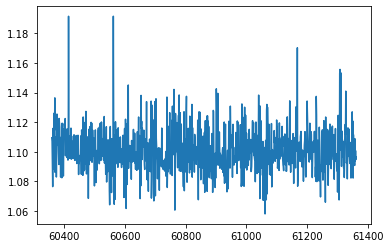

In [30]:
plt.plot(*zip(*running_loss[-1000:]))
plt.show()

In [ ]:
# https://discuss.pytorch.org/t/interpreting-loss-value/17665/3